In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import optics, beam, beamline2d
from lcls_beamline_toolbox.polyprojection.legendre import LegendreFit2D
import pickle

Can't find epics package. PPM_Imager class will not be supported


In [2]:
# run this the first time. Afterwards you can skip it.
fit_object = LegendreFit2D(256, 256, 16)
with open('Legendre_basis.pickle', 'wb') as f:    
    pickle.dump(fit_object, f, pickle.HIGHEST_PROTOCOL)

calculating Legendre polynomials
calculated Legendre polynomials


In [2]:
# Hard X-ray offset mirrors. Assuming perfect for now.
mr1l0 = optics.FlatMirror('mr1l0', length=1, alpha=2.1e-3, z=740,delta=0e-9)
mr2l0 = optics.FlatMirror('mr2l0', length=1, alpha=2.1e-3, z=747.286)

# interaction point location for XPP
IP = optics.PPM('IP', FOV=2e-3, z=789)

# dummy height error
x=np.linspace(-1, 1, 100)
x,y = np.meshgrid(x,x)
# units are nm
bump_height = .05
height_error = bump_height*np.exp(-(x**2+y**2)/(2*.05)**2)

# approximate crystals as mirrors

# no deformation
crystal_perfect = optics.FlatMirror('crystal', z=IP.z, length=2e-3, width=2e-3, alpha=45*np.pi/180)
# with deformation
crystal_error = optics.FlatMirror('crystal', z=IP.z, length=2e-3, width=2e-3, alpha=45*np.pi/180, 
                                        shapeError=height_error)

# imager for wavefront sensor (approximately 6 meters downstream of interaction point)
WFS_YAG = optics.PPM('WFS_YAG', FOV=2e-3, blur=True, resolution=5e-3/2048, z=IP.z + 6)

# wavelength for 9.5 keV
lambda0 = 1239.8/9500*1e-9

# calculate proper grating position
# distance from source to imager
R2 = WFS_YAG.z - 630
# Talbot condition (using grating parameters where grating features are integer number of pixels)
R1 = R2/2*(1+np.sqrt(1-2*(12.56e-6)**2/lambda0/R2))

print('Talbot distance: %.2f meters' % (R2-R1))

# put wavefront sensor at 3rd Talbot plane to gain a bit of sensitivity
WFS = optics.WFS('XPP_WFS', pitch=10e-6, duty_cycle=1, phase=True, z=WFS_YAG.z-3*(R2-R1))
# WFS.disable()

print('grating to imager distance: %.2f meters' % (WFS_YAG.z-WFS.z))

# collect devices
devices = [mr1l0,mr2l0,IP,WFS,WFS_YAG,crystal_perfect]

# array/beam parameters
N = 2048
# beam energy in eV
E0 = 9500.

# 
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 15e-6,
    'sigma_y': 15e-6,
    'z0x': mr1l0.z-630,
    'z0y': mr1l0.z-630,
    'rangeFactor': 5
}

# initialize beam
b1 = beam.Beam(beam_params=beam_params)

# initialize beamline
XPP = beamline2d.Beamline(devices)
# -----  propagate first with perfect crystal
XPP.propagate_beamline(b1)

Talbot distance: 0.61 meters
grating to imager distance: 1.82 meters
FWHM in x: 359.90462293506476 microns
FWHM in y: 359.90462293506476 microns
FWHM Divergence (x): 3.3 μrad
FWHM Divergence (y): 3.3 μrad
mr1l0
drift1
zRx: 77610176.25 microns
zRy: 77761980.96 microns
remaining distance: 7286000.00 microns
goal for zx: 117286000.00 microns
current zx: 110000000.00 microns
goal for zy: 117286000.00 microns
current zy: 110000000.00 microns
mr2l0
drift2
zRx: 77761980.96 microns
zRy: 77761980.96 microns
remaining distance: 41714000.00 microns
goal for zx: 159000000.00 microns
current zx: 117286000.00 microns
goal for zy: 159000000.00 microns
current zy: 117286000.00 microns
IP
crystal
drift3
drift4
zRx: 77610176.25 microns
zRy: 77761980.96 microns
remaining distance: 4180122.54 microns
goal for zx: 163180122.54 microns
current zx: 159000000.00 microns
goal for zy: 163180122.54 microns
current zy: 159000000.00 microns
XPP_WFS
actual pitch: 12.51 microns
drift5
zRx: 77610176.25 microns
zRy: 7

<IPython.core.display.Javascript object>


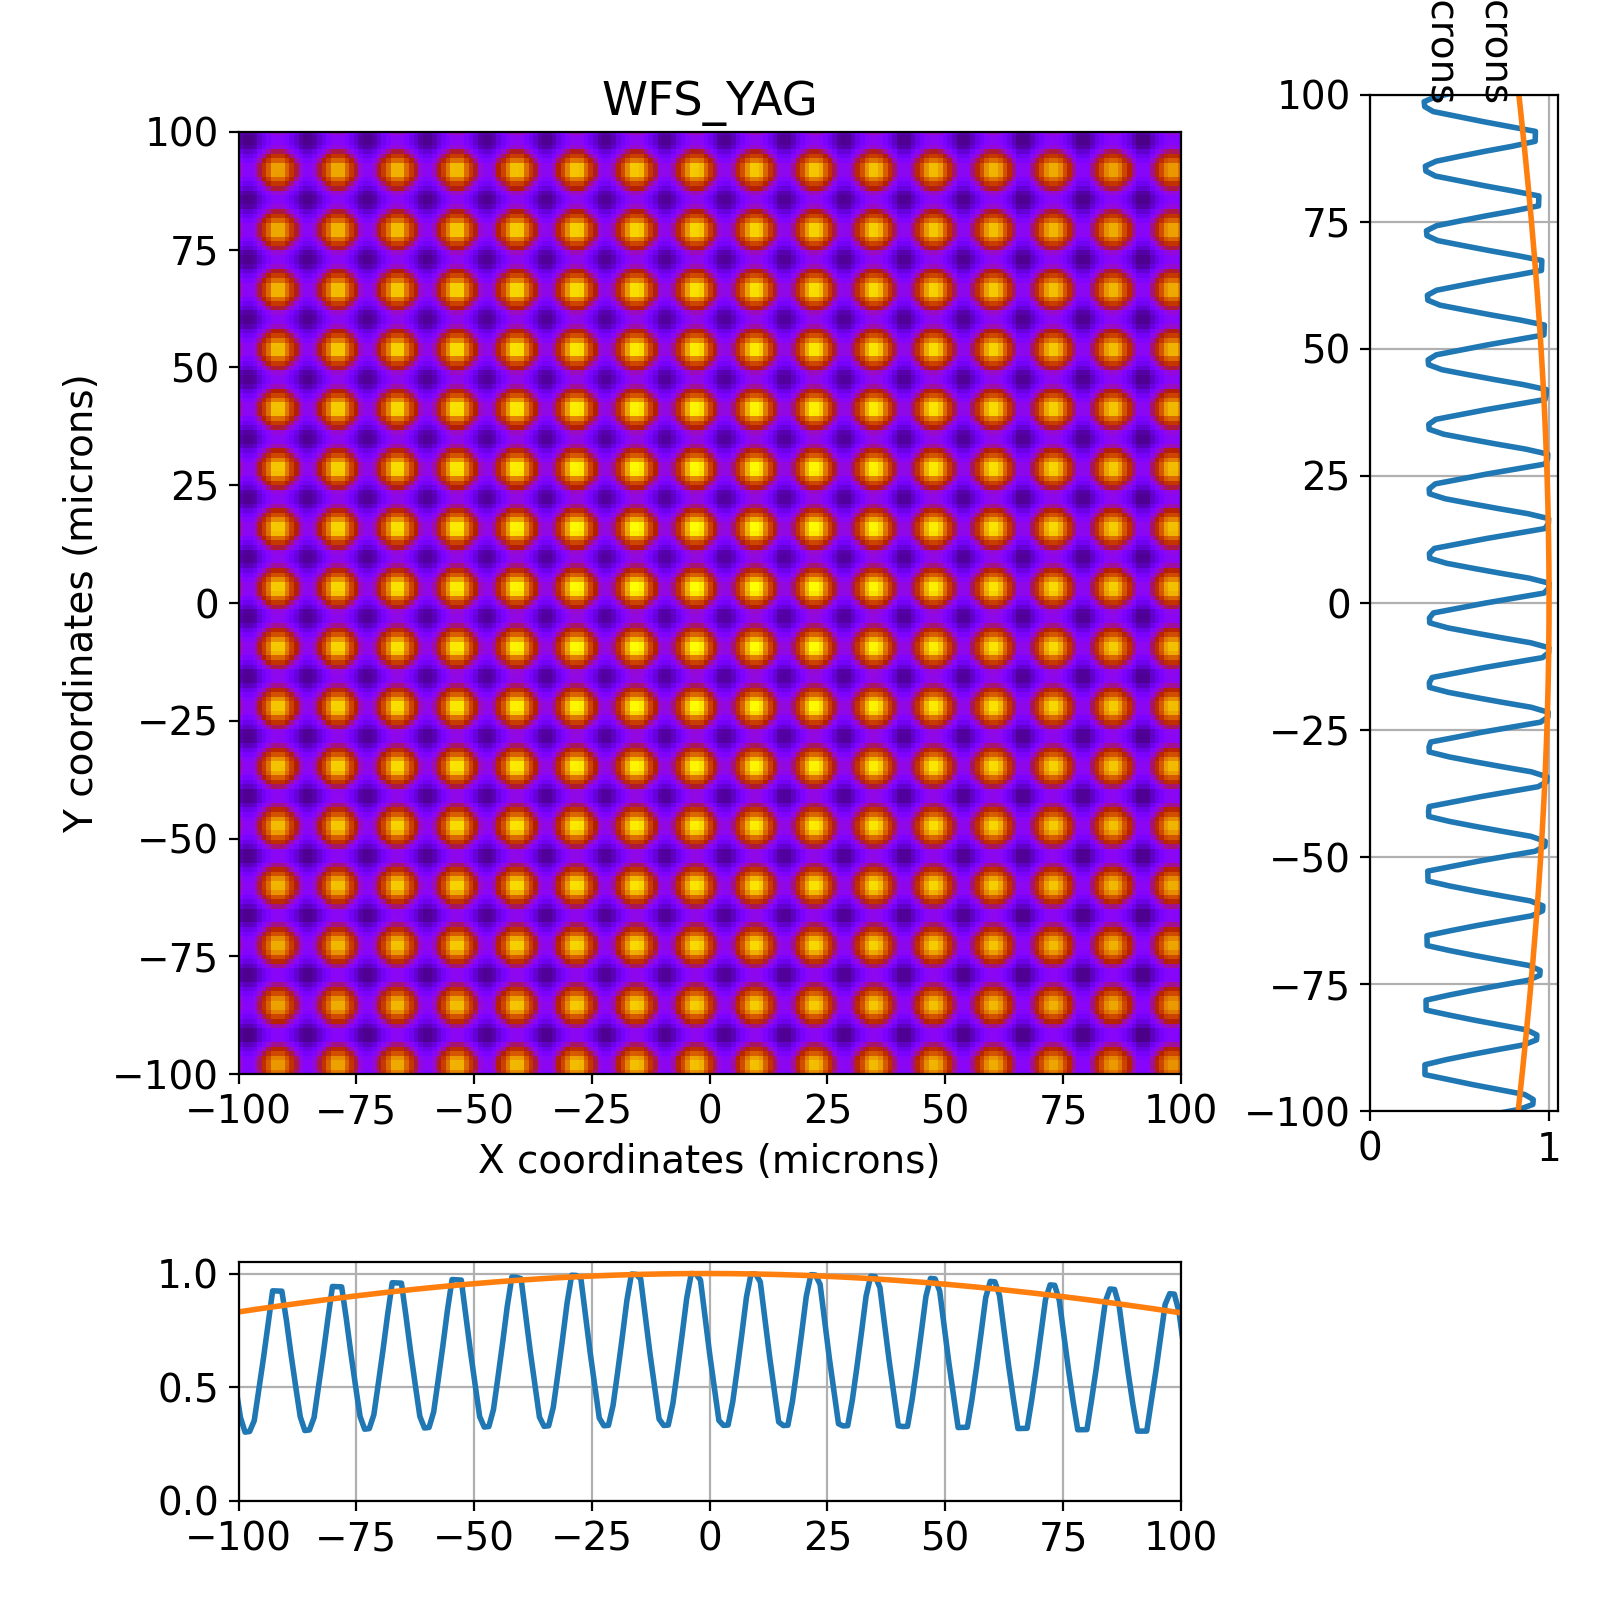

(-100.0, 100.0)

In [3]:
fig_path = '/Users/Matt/OneDrive - SLAC National Accelerator Laboratory/Projects/Crystal Optics Thermal Model/HXRSS experiment'
axes = XPP.WFS_YAG.view_beam()
profile = axes[0]
profile.set_xlim(-100,100)
profile.set_ylim(-100,100)
axes[1].set_xlim(-100,100)
axes[2].set_ylim(-100,100)
# plt.savefig(fig_path+'/wfs_zoom.png')

In [4]:
# retrieve wavefront
wfs_data_0 = XPP.WFS_YAG.retrieve_wavefront2D('Legendre_basis.pickle', XPP.XPP_WFS)

# -----  now propagate with deformed crystal
# collect devices
devices = [mr1l0,mr2l0,IP,WFS,WFS_YAG,crystal_error]
# initialize beamline
XPP = beamline2d.Beamline(devices)
# -----  propagate first with perfect crystal
XPP.propagate_beamline(b1)

# retrieve wavefront
wfs_data_1 = XPP.WFS_YAG.retrieve_wavefront2D('Legendre_basis.pickle', XPP.XPP_WFS)

retrieving wavefront
retrieving wavefront
getting lineouts
dxprime: 1.0
12.956496798895628
dxprime: 1.0
12.956497189427118
getting Legendre coefficients
zf: 165.07954392298242
generating basis
calculating Legendre polynomials
calculated Legendre polynomials
generating matrix
matrix generated
basis generated
max1: 0.0003359375000000003
max2: 0.0003349609375
zf: 165.0790975506189
generating basis
calculating Legendre polynomials
calculated Legendre polynomials
generating matrix
matrix generated
basis generated
max1: 0.0003359375000000003
max2: 0.0003349609375
found Legendre coefficients
Distance to source: 165.02548141397668
Distance to source: 165.0255536543815
getting 2D Legendre coefficients
magnification: 0.8
mr1l0
drift1
zRx: 77610176.25 microns
zRy: 77761980.96 microns
remaining distance: 7286000.00 microns
goal for zx: 117286000.00 microns
current zx: 110000000.00 microns
goal for zy: 117286000.00 microns
current zy: 110000000.00 microns
mr2l0
drift2
zRx: 77761980.96 microns
zRy: 

# Wavefront comparison

Comparison between crystal with and without dummy thermal bump.

<IPython.core.display.Javascript object>


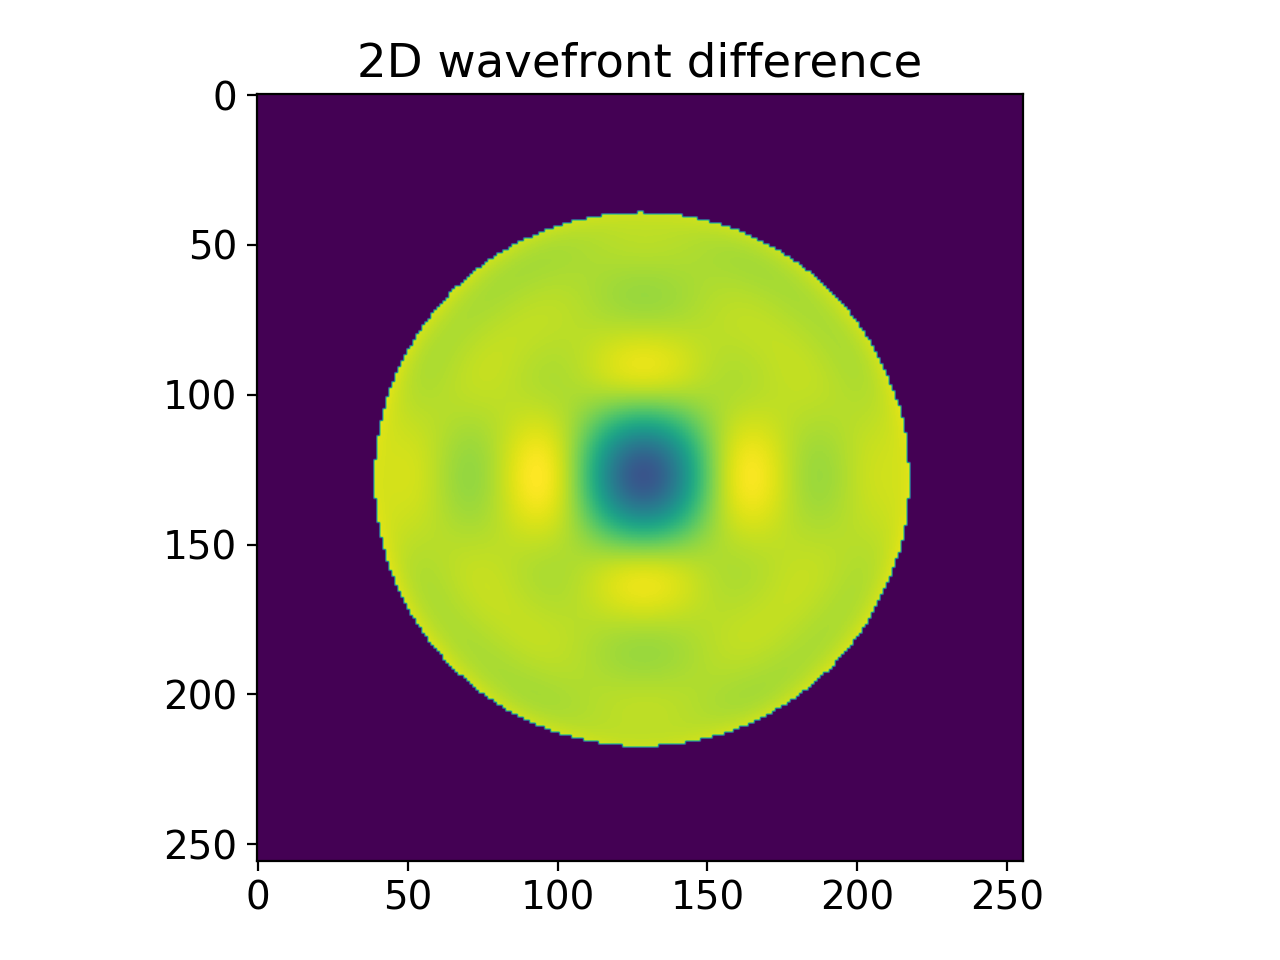

<IPython.core.display.Javascript object>


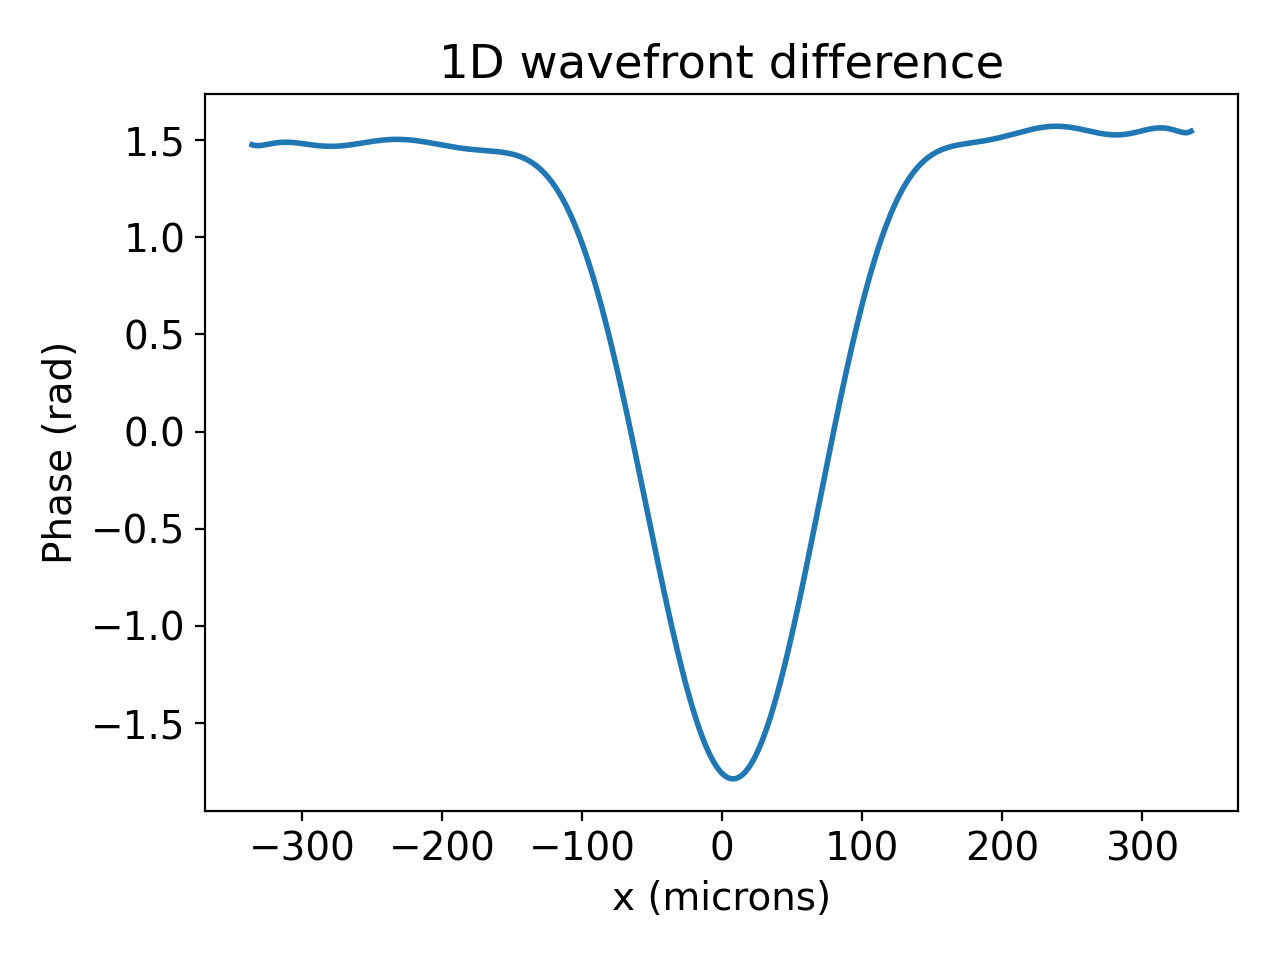

measured shift: 3.36 radians
actual shift: 3.40 radians


In [5]:
# compare wavefronts
wave0 = wfs_data_0['wave']
wave1 = wfs_data_1['wave']

mask = np.abs(wfs_data_0['recovered'])>0

plt.figure()
plt.imshow((wave1-wave0)*mask)
plt.title('2D wavefront difference')

# compare in 1D
x = wfs_data_0['x_prime']
zx0 = wfs_data_0['z2x']
zx1 = wfs_data_1['z2x']

wave0 = wfs_data_0['x_res'] + np.pi/b1.lambda0/zx0 * (x*1e-6)**2
wave1 = wfs_data_1['x_res'] + np.pi/b1.lambda0/zx1 * (x*1e-6)**2

wave_diff = wave1-wave0

plt.figure()
plt.plot(x,wave_diff)
plt.xlabel('x (microns)')
plt.ylabel('Phase (rad)')
plt.title('1D wavefront difference')

# measured phase shift
phase_shift = np.max(wave_diff) - np.min(wave_diff)

# actual phase shift
actual_shift = (bump_height*1e-9)/b1.lambda0 * 4 * np.pi * np.sin(crystal_perfect.alpha)
print('measured shift: %.2f radians' % phase_shift)
print('actual shift: %.2f radians' % actual_shift)

# Wavefront sensor image

This is roughly what the wavefront sensor image will look like.

<IPython.core.display.Javascript object>


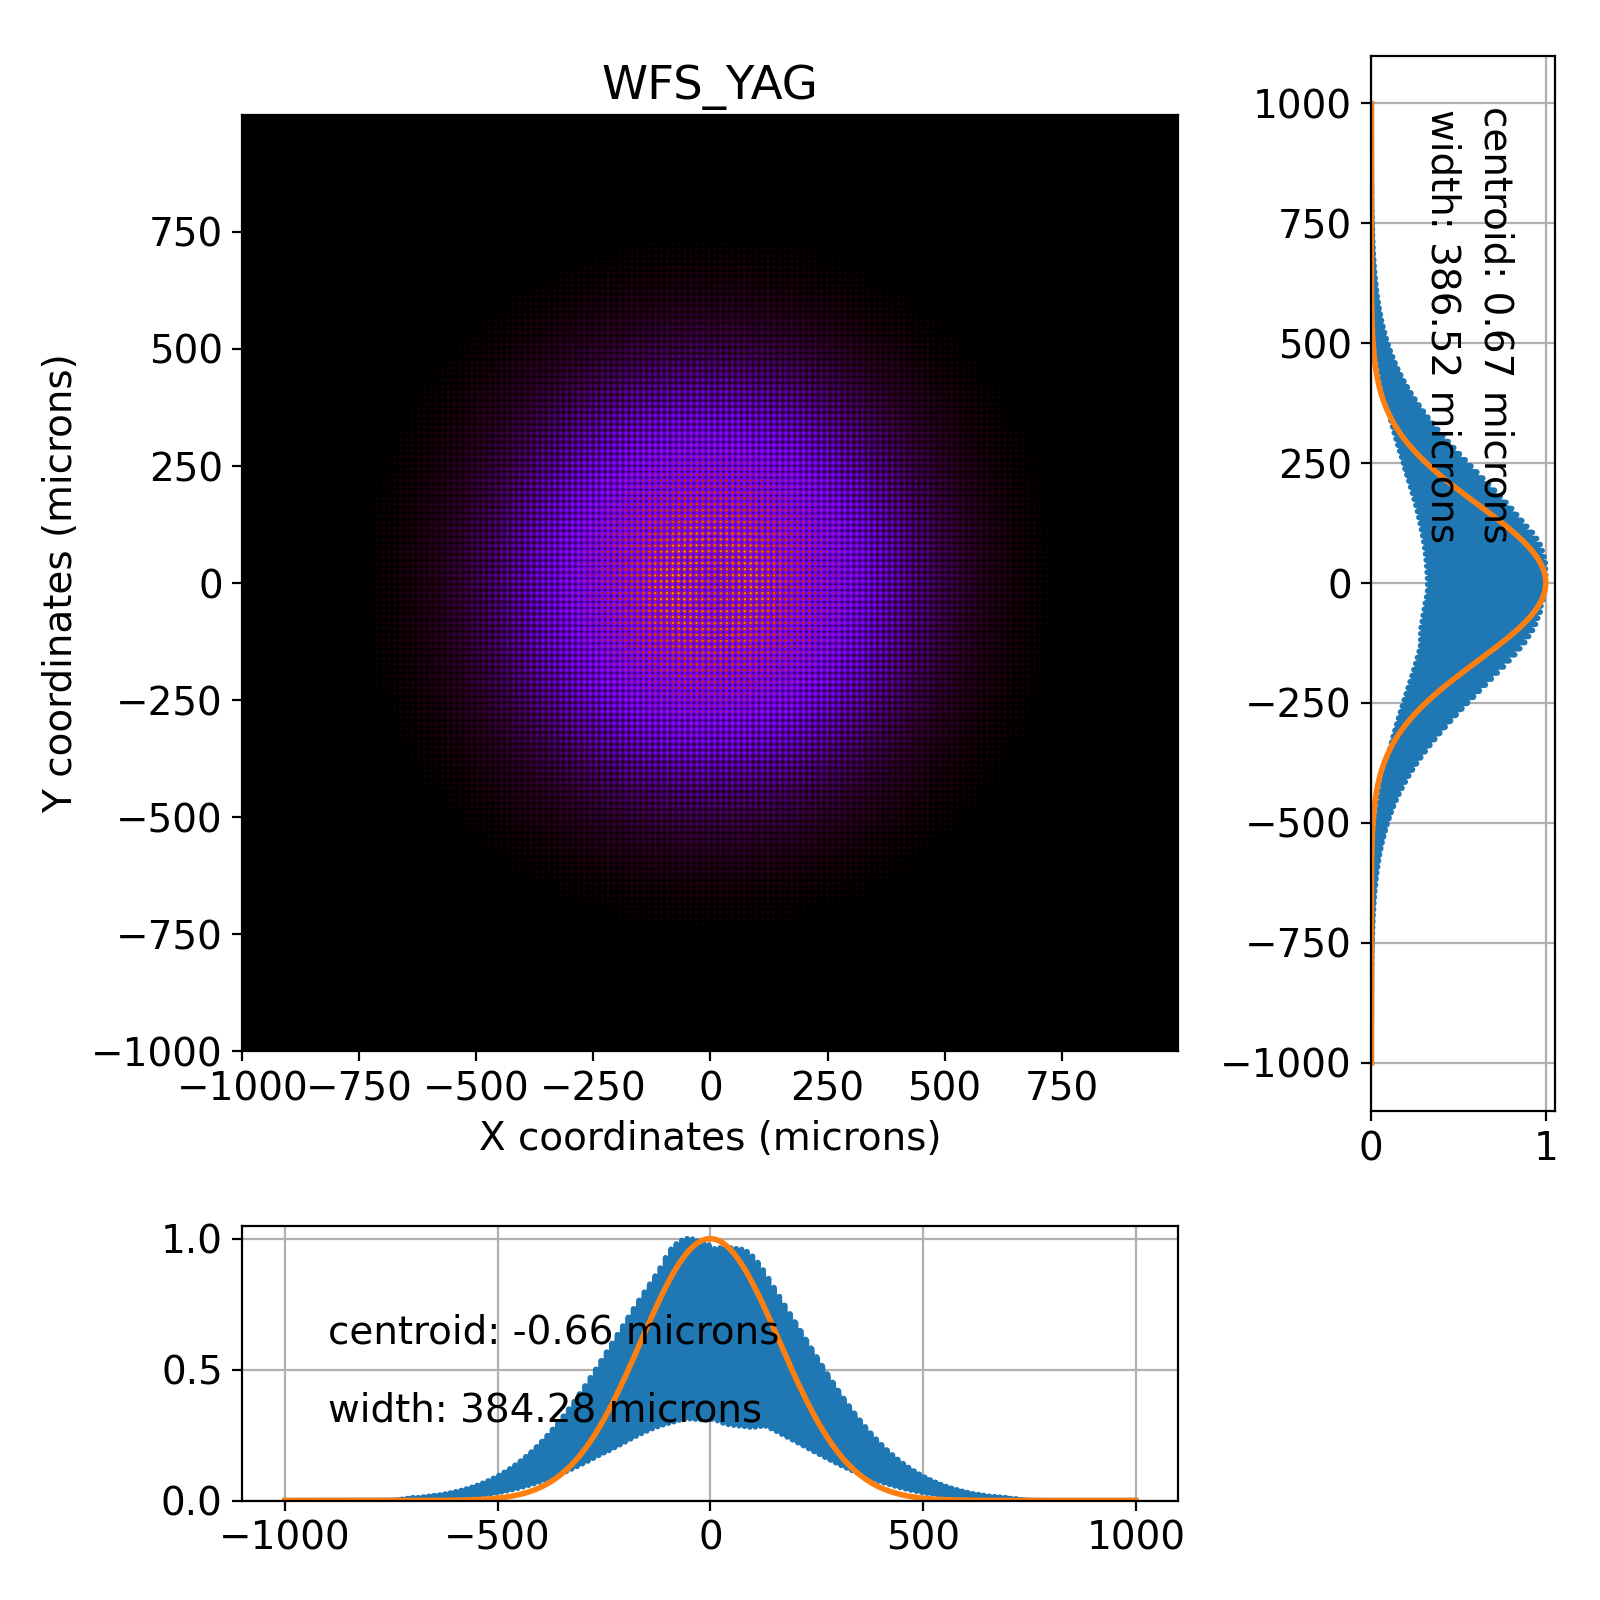

In [6]:
XPP.WFS_YAG.view_beam()